**Section 9B** <br>
3/6/25

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import kagglehub
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
import os
from scipy.signal import convolve2d
from tensorflow.keras.utils import to_categorical
import struct
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score

# Task 1: Multilayer Preceptron (MLP)

**A)**

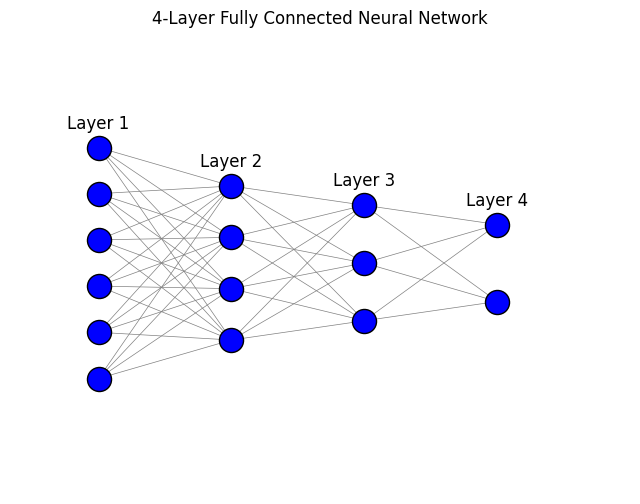

In [2]:
def draw_neural_network(ax, layer_sizes):
    """ Draws a simple schematic of a fully connected neural network. """
    v_spacing = 1.0  # Vertical spacing between neurons
    h_spacing = 1.5  # Horizontal spacing between layers
    
    max_neurons = max(layer_sizes)
    positions = []
    
    # Calculate neuron positions
    for i, size in enumerate(layer_sizes):
        x = i * h_spacing
        y = np.linspace(-size/2, size/2, size) * v_spacing
        positions.append((x, y))
        
    # Draw connections
    for i in range(len(layer_sizes) - 1):
        x1, y1 = positions[i]
        x2, y2 = positions[i + 1]
        for y_start in y1:
            for y_end in y2:
                ax.plot([x1, x2], [y_start, y_end], 'gray', lw=0.5)
    
    # Draw neurons
    for x, y in positions:
        ax.scatter([x] * len(y), y, s=300, color='blue', edgecolors='black', zorder=3)
    
    # Annotate layers
    for i, (x, y) in enumerate(positions):
        ax.text(x, max(y) + 0.5, f'Layer {i+1}', fontsize=12, ha='center')
    
    ax.set_xlim(-1, len(layer_sizes) * h_spacing)
    ax.set_ylim(-max_neurons, max_neurons)
    ax.axis('off')

# Define the neural network structure
layer_sizes = [6, 4, 3, 2]  # Number of neurons in each layer

fig, ax = plt.subplots(figsize=(8, 6))
draw_neural_network(ax, layer_sizes)
plt.title("4-Layer Fully Connected Neural Network")
plt.show()

**B)**

In [21]:
class MLP:
    def __init__(self, layer_sizes, activation='relu', learning_rate=0.01):
        """ Initialize a fully connected MLP. """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.activation_func = self.relu if activation == 'relu' else self.sigmoid
        self.activation_deriv = self.relu_deriv if activation == 'relu' else self.sigmoid_deriv
        
        # Initialize weights and biases
        self.weights = [np.random.randn(o, i) * 0.1 for i, o in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((o, 1)) for o in layer_sizes[1:]]

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_deriv(self, x):
        return (x > 0).astype(float)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_deriv(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # Numerical stability
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)
    
    def forward(self, x):
        """ Forward pass through the network. """
        activations, zs = [x], []
        for W, b in zip(self.weights[:-1], self.biases[:-1]):
            z = np.dot(W, activations[-1]) + b
            zs.append(z)
            activations.append(self.activation_func(z))

        # Last layer (softmax for classification)
        z_final = np.dot(self.weights[-1], activations[-1]) + self.biases[-1]
        zs.append(z_final)
        activations.append(self.softmax(z_final))
        
        return activations, zs
    
    def backward(self, x, y):
        """ Backward pass to compute gradients. """
        activations, zs = self.forward(x)
        grads_w, grads_b = [None] * len(self.weights), [None] * len(self.biases)
        
        # Compute output layer error (cross-entropy loss derivative)
        delta = activations[-1] - y
        grads_w[-1] = np.dot(delta, activations[-2].T) / x.shape[1]
        grads_b[-1] = np.mean(delta, axis=1, keepdims=True)

        # Backpropagate error
        for l in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(self.weights[l + 1].T, delta) * self.activation_deriv(zs[l])
            grads_w[l] = np.dot(delta, activations[l].T) / x.shape[1]
            grads_b[l] = np.mean(delta, axis=1, keepdims=True)
        
        return grads_w, grads_b
    
    def update_params(self, grads_w, grads_b):
        """ Update weights and biases using gradient descent. """
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_w[i]
            self.biases[i] -= self.learning_rate * grads_b[i]

    # def train(self, x, y, epochs=50, batch_size=64):
    #     """ Train the MLP using mini-batch gradient descent. """
    #     num_samples = x.shape[1]
    #     for epoch in range(epochs):
    #         # Shuffle data
    #         indices = np.random.permutation(num_samples)
    #         x_shuffled, y_shuffled = x[:, indices], y[:, indices]

    #         # Mini-batch training
    #         for i in range(0, num_samples, batch_size):
    #             x_batch = x_shuffled[:, i:i+batch_size]
    #             y_batch = y_shuffled[:, i:i+batch_size]
    #             grads_w, grads_b = self.backward(x_batch, y_batch)
    #             self.update_params(grads_w, grads_b)

    #         if epoch % 10 == 0:
    #             loss = -np.mean(y * np.log(self.forward(x)[0][-1] + 1e-8))  # Cross-entropy loss
    #             print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def train(self, x, y, epochs=50, batch_size=64):
        """ Train the MLP using mini-batch gradient descent and store loss history. """
        num_samples = x.shape[1]
        self.loss_history = []  # Store loss values

        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(num_samples)
            x_shuffled, y_shuffled = x[:, indices], y[:, indices]

            # Mini-batch training
            for i in range(0, num_samples, batch_size):
                x_batch = x_shuffled[:, i:i+batch_size]
                y_batch = y_shuffled[:, i:i+batch_size]
                grads_w, grads_b = self.backward(x_batch, y_batch)
                self.update_params(grads_w, grads_b)

            # Compute loss after each epoch and store it
            loss = -np.mean(y * np.log(self.forward(x)[0][-1] + 1e-8))  # Cross-entropy loss
            self.loss_history.append(loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, x):
        """ Predict class labels for input data. """
        return np.argmax(self.forward(x)[0][-1], axis=0)

# Task 2: Convolutional Neural Network (CNN)

**A)**

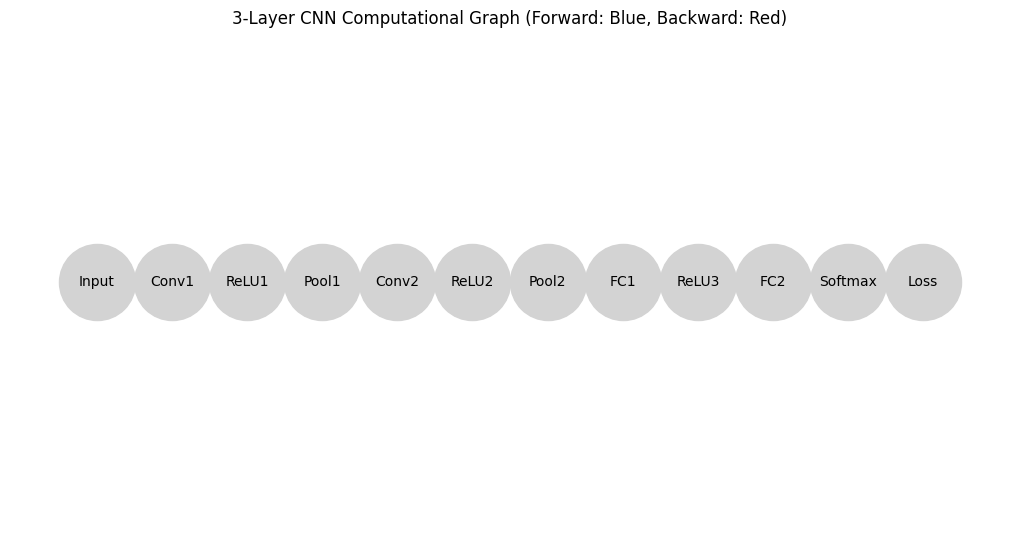

In [6]:
def draw_cnn_graph():
    """Draws a computational graph for a 3-layer CNN with forward and backward propagation."""
    G = nx.DiGraph()
    
    # Define nodes
    layers = {
        "Input": (0, 3),
        "Conv1": (1, 3),
        "ReLU1": (2, 3),
        "Pool1": (3, 3),
        "Conv2": (4, 3),
        "ReLU2": (5, 3),
        "Pool2": (6, 3),
        "FC1": (7, 3),
        "ReLU3": (8, 3),
        "FC2": (9, 3),
        "Softmax": (10, 3),
        "Loss": (11, 3)
    }
    
    # Add forward edges
    forward_edges = [
        ("Input", "Conv1"),
        ("Conv1", "ReLU1"),
        ("ReLU1", "Pool1"),
        ("Pool1", "Conv2"),
        ("Conv2", "ReLU2"),
        ("ReLU2", "Pool2"),
        ("Pool2", "FC1"),
        ("FC1", "ReLU3"),
        ("ReLU3", "FC2"),
        ("FC2", "Softmax"),
        ("Softmax", "Loss")
    ]
    
    # Add backward edges (gradient flow)
    backward_edges = [(b, a) for a, b in forward_edges]
    
    G.add_edges_from(forward_edges, color='blue')
    G.add_edges_from(backward_edges, color='red')
    
    # Draw graph
    pos = layers
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    plt.figure(figsize=(10, 5))
    nx.draw(G, pos, with_labels=True, node_color='lightgray', edge_color=edge_colors, node_size=3000, font_size=10)
    plt.title("3-Layer CNN Computational Graph (Forward: Blue, Backward: Red)")
    plt.show()

# Draw the computational graph
draw_cnn_graph()

**B)**

In [41]:
class CNN:
    def __init__(self, input_shape, conv_layers, fc_layers, activation='relu', learning_rate=0.01):
        """ Initialize a simple CNN model. """
        self.input_shape = input_shape  # (channels, height, width)
        self.conv_layers = conv_layers  # List of (num_filters, kernel_shape) tuples
        self.fc_layers = fc_layers  # Fully connected layer sizes
        self.learning_rate = learning_rate
        
        # Activation function
        self.activation_func = self.relu if activation == 'relu' else self.sigmoid
        self.activation_deriv = self.relu_deriv if activation == 'relu' else self.sigmoid_deriv

        # Initialize convolutional layers
        self.conv_weights = [np.random.randn(f, *k) * 0.1 for f, k in conv_layers]
        self.conv_biases = [np.zeros((f, 1, 1)) for f, _ in conv_layers]

        # Initialize fully connected layers
        self.fc_weights = [np.random.randn(o, i) * 0.1 for i, o in zip(fc_layers[:-1], fc_layers[1:])]
        self.fc_biases = [np.zeros((o, 1)) for o in fc_layers[1:]]

    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return (x > 0).astype(float)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_deriv(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)
    
    def max_pool(self, x, pool_size=2):
        """ Max pooling operation (2x2 by default) """
        pooled = x[:, ::pool_size, ::pool_size]  # Simple downsampling (stride = pool_size)
        return pooled

    def forward(self, x):
        """ Forward pass through the CNN. """
        activations, zs = [x], []

        # Convolutional layers
        for W, b in zip(self.conv_weights, self.conv_biases):
            z = np.array([sum(convolve2d(xi.squeeze(), Wi.squeeze(), mode='valid') for Wi in W) + b for xi in x])
            zs.append(z)
            a = self.activation_func(z)
            a_pooled = self.max_pool(a)  # Apply max pooling
            activations.append(a_pooled)

        # Flatten before FC layers
        batch_size = activations[-1].shape[0]  # Get batch size
        flattened_size = np.prod(activations[-1].shape[1:])  # Compute total features per sample

        x_flattened = activations[-1].reshape(batch_size, flattened_size)  # Flatten correctly
        activations.append(x_flattened)

        # Fully connected layers
        for W, b in zip(self.fc_weights, self.fc_biases):
            z = np.dot(W, activations[-1]) + b
            zs.append(z)
            activations.append(self.activation_func(z))

        # Apply softmax at the output layer
        activations[-1] = self.softmax(activations[-1])

        return activations, zs

    def backward(self, x, y):
        """ Backward pass to compute gradients. """
        activations, zs = self.forward(x)
        grads_w, grads_b = [None] * len(self.fc_weights), [None] * len(self.fc_biases)

        # Compute softmax loss derivative
        delta = activations[-1] - y  # dL/dZ for softmax + cross-entropy
        grads_w[-1] = np.dot(delta, activations[-2].T) / x.shape[0]
        grads_b[-1] = np.mean(delta, axis=1, keepdims=True)

        # Backpropagate through FC layers
        for l in range(len(self.fc_weights) - 2, -1, -1):
            delta = np.dot(self.fc_weights[l + 1].T, delta) * self.activation_deriv(zs[l])
            grads_w[l] = np.dot(delta, activations[l].T) / x.shape[0]
            grads_b[l] = np.mean(delta, axis=1, keepdims=True)

        return grads_w, grads_b

    def update_params(self, grads_w, grads_b):
        """ Update weights and biases using gradient descent. """
        for i in range(len(self.fc_weights)):
            self.fc_weights[i] -= self.learning_rate * grads_w[i]
            self.fc_biases[i] -= self.learning_rate * grads_b[i]

    def train(self, x, y, epochs=100, batch_size=64):
        """ Train the CNN using mini-batch gradient descent. """
        num_samples = x.shape[0]
        loss_history = []

        for epoch in range(epochs):
            indices = np.random.permutation(num_samples)
            x_shuffled, y_shuffled = x[indices], y[indices]

            for i in range(0, num_samples, batch_size):
                x_batch = x_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                grads_w, grads_b = self.backward(x_batch, y_batch)
                self.update_params(grads_w, grads_b)

            # Compute loss
            loss = -np.mean(y * np.log(self.forward(x)[0][-1] + 1e-8))  # Cross-entropy loss
            loss_history.append(loss)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

        # Plot loss convergence
        plt.plot(range(epochs), loss_history, label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('CNN Training Convergence')
        plt.legend()
        plt.show()

    def draw_cnn_graph(self):
        """Draws a computational graph for a 3-layer CNN with forward and backward propagation."""
        G = nx.DiGraph()
        layers = {
            "Input": (0, 3), "Conv1": (1, 3), "ReLU1": (2, 3), "Pool1": (3, 3),
            "Conv2": (4, 3), "ReLU2": (5, 3), "Pool2": (6, 3), "FC1": (7, 3),
            "ReLU3": (8, 3), "FC2": (9, 3), "Softmax": (10, 3), "Loss": (11, 3)
        }
        forward_edges = [("Input", "Conv1"), ("Conv1", "ReLU1"), ("ReLU1", "Pool1"),
                         ("Pool1", "Conv2"), ("Conv2", "ReLU2"), ("ReLU2", "Pool2"),
                         ("Pool2", "FC1"), ("FC1", "ReLU3"), ("ReLU3", "FC2"),
                         ("FC2", "Softmax"), ("Softmax", "Loss")]
        backward_edges = [(b, a) for a, b in forward_edges]
        G.add_edges_from(forward_edges, color='blue')
        G.add_edges_from(backward_edges, color='red')
        pos = layers
        edge_colors = [G[u][v]['color'] for u, v in G.edges()]
        plt.figure(figsize=(10, 5))
        nx.draw(G, pos, with_labels=True, node_color='lightgray', edge_color=edge_colors, node_size=3000, font_size=10)
        plt.title("3-Layer CNN Computational Graph (Forward: Blue, Backward: Red)")
        plt.show()

# Task 3: MNIST dataset: Training and validation of MLP and CNN

In [6]:
# Function to load IDX files
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
    return data / 255.0  # Normalize pixel values

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Load dataset
data_path = "./archive"  # Change this if the folder is elsewhere
x_train = load_mnist_images(os.path.join(data_path, "train-images.idx3-ubyte"))
y_train = load_mnist_labels(os.path.join(data_path, "train-labels.idx1-ubyte"))
x_test = load_mnist_images(os.path.join(data_path, "t10k-images.idx3-ubyte"))
y_test = load_mnist_labels(os.path.join(data_path, "t10k-labels.idx1-ubyte"))

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Reshape for CNN: (N, 28, 28, 1) and for MLP: (N, 784)
x_train_cnn, x_test_cnn = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train_mlp, x_test_mlp = x_train.reshape(-1, 784), x_test.reshape(-1, 784)

# Split dataset into 80-20 train-test
x_train_cnn, x_val_cnn, y_train_cnn, y_val_cnn = train_test_split(x_train_cnn, y_train, test_size=0.2, random_state=42)
x_train_mlp, x_val_mlp, y_train_mlp, y_val_mlp = train_test_split(x_train_mlp, y_train, test_size=0.2, random_state=42)

# Now, train your MLP and CNN models using x_train_mlp, y_train_mlp and x_train_cnn, y_train_cnn
print("Data loaded and split successfully!")

Data loaded and split successfully!


In [22]:
# Flatten images for MLP (reshape only once before train-test split)
x_train_mlp = x_train.reshape(-1, 784)
x_test_mlp = x_test.reshape(-1, 784)

# Train-validation split (80-20)
x_train_mlp, x_val_mlp, y_train_mlp, y_val_mlp = train_test_split(x_train_mlp, y_train, test_size=0.2, random_state=42)

# Transpose for compatibility with MLP implementation (if needed)
x_train_mlp, x_val_mlp = x_train_mlp.T, x_val_mlp.T
y_train_mlp, y_val_mlp = y_train_mlp.T, y_val_mlp.T

# Define and train the model
mlp_model = MLP(layer_sizes=[784, 128, 64, 10], activation='relu', learning_rate=0.01)
mlp_model.train(x_train_mlp, y_train_mlp, epochs=50, batch_size=64)

# Evaluate on validation set
y_pred = mlp_model.predict(x_val_mlp)
y_true = np.argmax(y_val_mlp, axis=0)

# Compute accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Epoch 0, Loss: 0.0550
Epoch 10, Loss: 0.0207
Epoch 20, Loss: 0.0138
Epoch 30, Loss: 0.0102
Epoch 40, Loss: 0.0079
Validation Accuracy: 96.70%


In [23]:
# Convert list of weights and biases to arrays before saving
weights_arr = np.array(mlp_model.weights, dtype=object)
biases_arr = np.array(mlp_model.biases, dtype=object)

# Save model parameters
np.savez("mlp_model.npz", weights=weights_arr, biases=biases_arr)
print("Model saved successfully!")

Model saved successfully!


In [24]:
# Load saved model parameters
data = np.load("mlp_model.npz", allow_pickle=True)
mlp_model.weights = list(data["weights"])
mlp_model.biases = list(data["biases"])
print("Model loaded successfully!")

Model loaded successfully!


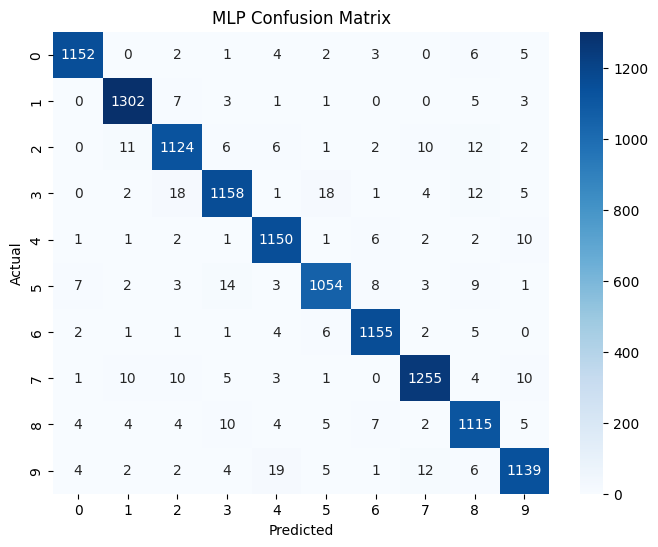

In [25]:
# Get model predictions
y_pred_mlp = mlp_model.predict(x_val_mlp)  # Ensure this returns an array

# Debugging: Print the shape of raw predictions
# print("Raw y_pred_mlp shape:", y_pred_mlp.shape)

# Ensure predictions are converted properly
if y_pred_mlp.ndim == 2:  # If shape is (num_classes, num_samples), take argmax along axis=0
    y_pred_mlp = np.argmax(y_pred_mlp, axis=0)
elif y_pred_mlp.ndim == 1:  # If shape is (num_samples,), it might already be correct
    pass
else:
    raise ValueError(f"Unexpected y_pred_mlp shape: {y_pred_mlp.shape}")

# Convert true labels from one-hot encoding
y_true_mlp = np.argmax(y_val_mlp, axis=0)

# Debugging: Print shapes
# print("Final y_pred_mlp shape:", y_pred_mlp.shape)
# print("y_true_mlp shape:", y_true_mlp.shape)

cm = confusion_matrix(y_true_mlp, y_pred_mlp)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("MLP Confusion Matrix")
plt.savefig("mlp_confusion_matrix.png")
plt.show()

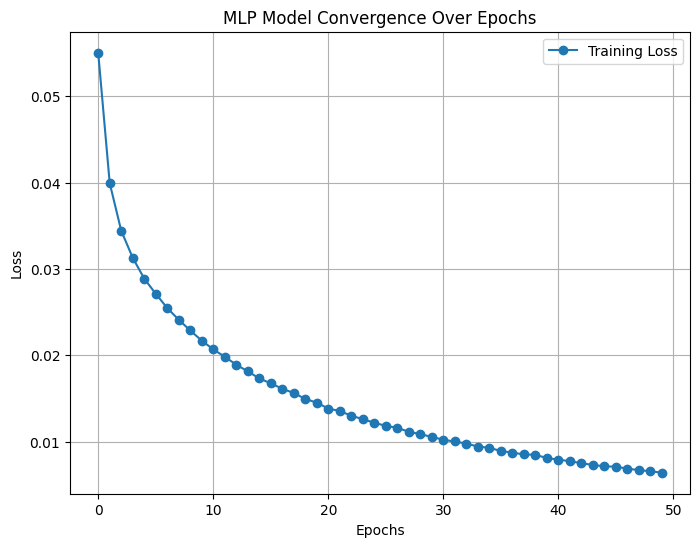

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(mlp_model.loss_history)), mlp_model.loss_history, marker='o', linestyle='-', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MLP Model Convergence Over Epochs")
plt.legend()
plt.grid()
plt.savefig("MLP_convergence_vs_epochs.png")
plt.show()

Now for the CNN model. 

In [ ]:
# Ensure the dataset has the correct format (28x28 grayscale images)
x_train_cnn = x_train.reshape(-1, 1, 28, 28)  # Keep channel dimension
x_test_cnn = x_test.reshape(-1, 1, 28, 28)

# Train-validation split (80-20)
x_train_cnn, x_val_cnn, y_train_cnn, y_val_cnn = train_test_split(x_train_cnn, y_train, test_size=0.2, random_state=42)

# Convert labels to integer type
y_train_cnn = y_train_cnn.astype(int)
y_val_cnn = y_val_cnn.astype(int)

# Convert labels to one-hot encoding (with correct shape)
num_classes = 10
y_train_one_hot = np.eye(num_classes)[y_train_cnn].T  # Transpose to match sample count
y_val_one_hot = np.eye(num_classes)[y_val_cnn].T      # Transpose for validation labels

# Transpose for compatibility with CNN implementation (if needed)
x_train_cnn, x_val_cnn = x_train_cnn.transpose(0, 2, 3, 1), x_val_cnn.transpose(0, 2, 3, 1)  # Change to (batch, height, width, channels)
y_train_one_hot, y_val_one_hot = y_train_one_hot.T, y_val_one_hot.T  # Transpose labels if required

# Define and train the CNN model
flattened_size = np.prod(conv_output_shape)  # Compute this based on convolution output
cnn_model = CNN(input_shape=(1, 28, 28), conv_layers=[(8, (3, 3)), (16, (3, 3))], fc_layers=[flattened_size, 256, 128, 10], learning_rate=0.01)
cnn_model.train(x_train_cnn, y_train_one_hot, epochs=50, batch_size=64)

# Evaluate on validation set
y_pred_proba = cnn_model.forward(x_val_cnn)[0][-1]  # Get softmax output
y_pred = np.argmax(y_pred_proba, axis=0)  # Convert probabilities to class labels
y_true = np.argmax(y_val_one_hot, axis=0)  # True class labels

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

ValueError: shapes (128,256) and (64,2704) not aligned: 256 (dim 1) != 64 (dim 0)

In [32]:
# Function to save model parameters
def save_model(cnn, loss_history, filename="cnn_model.pkl"):
    model_data = {
        "conv_weights": cnn.conv_weights,
        "conv_biases": cnn.conv_biases,
        "fc_weights": cnn.fc_weights,
        "fc_biases": cnn.fc_biases,
        "loss_history": loss_history
    }
    with open(filename, "wb") as f:
        pickle.dump(model_data, f)
    print(f"Model saved to {filename}")

# Function to load model parameters
def load_model(filename="cnn_model.pkl"):
    with open(filename, "rb") as f:
        model_data = pickle.load(f)
    return model_data

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Function to plot loss convergence
def plot_loss_convergence(loss_history):
    plt.plot(range(len(loss_history)), loss_history, label="Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("CNN Training Convergence")
    plt.legend()
    plt.show()

# Training script
def train_cnn():
    # Simulated dataset: 1000 samples, 1-channel, 28x28 images, 10 classes
    num_samples = 1000
    num_classes = 10
    input_shape = (1, 28, 28)
    
    # Randomly generate dataset
    x_train = np.random.randn(num_samples, *input_shape)
    y_train = np.random.randint(0, num_classes, size=(num_samples,))
    
    # Convert labels to one-hot encoding
    y_one_hot = np.zeros((num_samples, num_classes))
    y_one_hot[np.arange(num_samples), y_train] = 1

    # Define CNN structure
    conv_layers = [(8, (3, 3)), (16, (3, 3))]  # 8 filters -> 16 filters
    fc_layers = [16 * 6 * 6, 64, num_classes]  # Flattened -> 64 -> 10

    # Initialize and train CNN
    cnn = CNN(input_shape, conv_layers, fc_layers, learning_rate=0.01)
    loss_history = cnn.train(x_train, y_one_hot, epochs=50, batch_size=32)

    # Save model
    save_model(cnn, loss_history)

    # Evaluate on training set
    activations, _ = cnn.forward(x_train)
    y_pred = np.argmax(activations[-1], axis=0)  # Convert softmax output to class labels

    # Plot confusion matrix
    plot_confusion_matrix(y_train, y_pred, classes=[str(i) for i in range(num_classes)])

    # Plot loss convergence
    plot_loss_convergence(loss_history)

# Run training
train_cnn()

ValueError: shapes (64,576) and (2704,32) not aligned: 576 (dim 1) != 2704 (dim 0)